In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from scipy.stats import normaltest

In [3]:
def pull_data(dbname = 'Seattle_housing', low_limit = 5000, year = 2018):
    """This function takes data from a postgreSQL database and returns a target dataframe and features dataframe."""
    engine = create_engine(f"postgresql:///{dbname}")
    query = f"""SELECT 
               *
            FROM rpsale rp
            JOIN resbldg rd
            ON CONCAT(rp."Major", rp."Minor") = Concat(rd."Major", rd."Minor")
            JOIN parcel p
            ON CONCAT(rp."Major", rp."Minor") = Concat(p."Major", p."Minor")
            WHERE "SalePrice" > {low_limit}
            AND SUBSTRING("DocumentDate", 7, 4) = '{year}'
         """
    seattle_housing = pd.read_sql(sql = query, con = engine)
    return seattle_housing

In [5]:
seattle_housing = pull_data()

In [6]:
def build_base(df = seattle_housing, target = 'SalePrice', basefeatures = ["SqFtTotLiving", "WfntLocation", "SqFtOpenPorch", "SqFtEnclosedPorch"]):    
    """This function builds the DataFrames that will be used to make the base model from the housing database."""
    target = df[[target]]
    features = pd.DataFrame()
    for feature in basefeatures:
        features = pd.concat([features, df[feature]], axis = 1)
    if ("SqFtOpenPorch" in features.columns) and ("SqFtEnclosedPorch" in features.columns):
        features['Porch'] = features['SqFtOpenPorch'] + features['SqFtEnclosedPorch']
        for i, row in features.iterrows():
            if row['Porch'] > 0:
                row['Porch'] = 1
            else:
                row['Porch'] = 0
        features = features.drop(["SqFtOpenPorch", "SqFtEnclosedPorch"], axis = 1)
    else:
        next
    if "WfntLocation" in features.columns:
        for i, row in features.iterrows():
            if row['WfntLocation'] > 0:
                row['WfntLocation'] = 1
            else:
                row['WfntLocation'] = 0
    else:
        next
    return target, features

In [ ]:
seattle_housing = pull_data()

In [7]:
target, features = build_base()

In [8]:
def scale_features(features = features):
    """Performs feature mean normalization using scikit learn StandardScaler."""
    ss = StandardScaler()
    scaled_features = pd.DataFrame(ss.fit_transform(features), columns = features.columns)
    return scaled_features

In [9]:
features = scale_features(features)

In [19]:
def model_eval(target = target, features = features):
    """Builds an OLS linear regression model based on target and features, returns a statsmodel summary, residual 
    plot, Q-Q plot, normality test result, correlation matrix plot for the features, and test for homoskedasticity."""
    model = sm.OLS(target, sm.add_constant(features)).fit()
    residuals = model.resid
    plt.style.use('seaborn-notebook')
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))
    sm.qqplot(residuals, ax=axes[(0, 0)], line='s')
    axes[(0,0)].set_title('Q-Q Plot')
    sns.residplot(target, residuals, ax=axes[(0, 1)])
    axes[(0,1)].set_title(f'{normaltest(residuals)}')
    axes[(0,1)].set_xlabel('Predicted')
    axes[(0,1)].set_ylabel('Residuals')
    sns.distplot(residuals, ax=axes[(1, 0)])
    axes[(1, 0)].set_title('Distribution of Residuals')
    sns.heatmap(features.corr(), ax = axes[(1,1)])
    axes[(1,1)].set_title('Features Correlation Matrix')    
    return model.summary()

/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     4025.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:22:52   Log-Likelihood:            -4.4453e+05
No. Observations:               30003   AIC:                         8.891e+05
Df Residuals:                   29999   BIC:                         8.891e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.315e+05   3800.215    218.802      0.000    8.24e+05    8.39e+05
SqFtTotLiving  3.829e+05   4021.355     95.212      0.000    3.75e+05    3.91e+05
WfntLocation   1.258e+05   3812.973     32.997      0.000    1.18e+05    1.33e+05
Porch          1.614e+04   4008.625      4.027      0.000    8284.235     2.4e+04
==============================================================================
Omnibus:                    39635.920   Durbin-Watson:                   0.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19444580.541
Skew:                           7.158   Prob(JB):                         0.00
Kurtosis:                     126.892   Cond. No.                         1.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

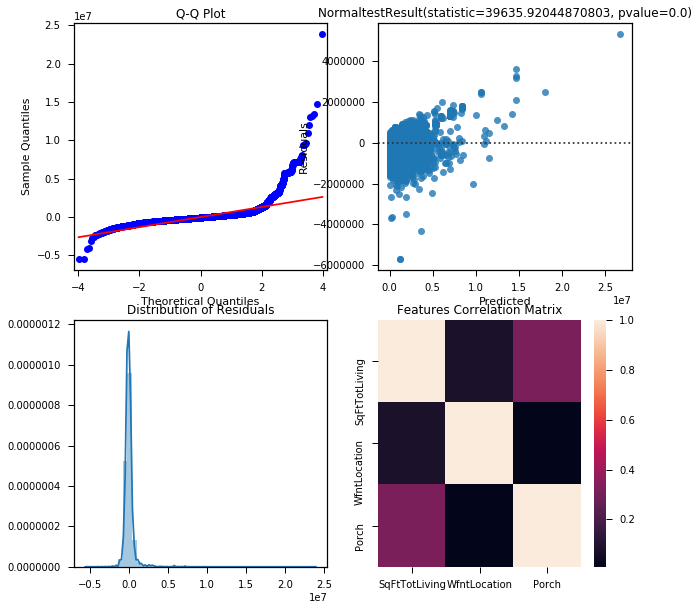

In [20]:
model_eval(target, features)

In [22]:
model = sm.OLS(target, sm.add_constant(features)).fit()

In [34]:
model.params.index[1]

'SqFtTotLiving'